### Tutorial 3: Downstream Analysis on mouse embryo slice

In this tutorial, we show how to use the stCAMBL reconstructed data of mouse embryo slice to perform downstream analysis. Relevant data can be obtained from https://drive.google.com/drive/folders/141__9Q4zYK_6A4stKsOE5WikIHgxFkhk

**Import the relevant python analysis package**

In [7]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

**Read data trained by stCAMBL**

In [8]:
# Load data
adata = sc.read_h5ad('/data3/yfchen/stCAMBL/data/E10.5_E2S1.MOSTA.h5ad')

**Find Marker Genes**

In [9]:
# sc.tl.rank_genes_groups(
#     adata, groupby='mclust', method='wilcoxon',
#     key_added='rank_genes'
# )

# # top-5 markers each cluster
# markers = {}
# for clust in adata.obs['mclust'].cat.categories:
#     markers[clust] = adata.uns['rank_genes']['names'][clust][0]

# Predefined gene list
gene_names = ['Papss2', 'Thbs2', 'Flrt2', 'Ogn', 'Sox5', 'Ldlrad4']
print(gene_names)  

['Papss2', 'Thbs2', 'Flrt2', 'Ogn', 'Sox5', 'Ldlrad4']


**Expression plot of marker genes**

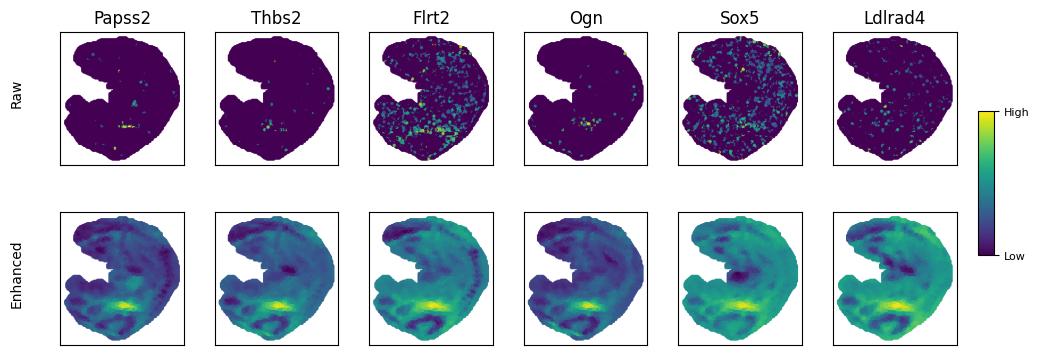

In [10]:
cmap = 'viridis'
pos = adata.obsm['spatial'] * np.array([1, -1])

# Column division
n_genes = len(gene_names)
n_cols  = 6                    
n_rows  = math.ceil(n_genes / n_cols)

# Canvas: provide enough width and height for each cell
fig, axes = plt.subplots(
    2 * n_rows, n_cols,
    figsize=(1.8 * n_cols, 1.8 * 2 * n_rows),
    constrained_layout=False    
)
axes = axes.reshape(2 * n_rows, n_cols)

# Adjust layout to make room for colorbar and space between subplots
fig.subplots_adjust(
    left=0.05, right=0.88,     
    bottom=0.05, top=0.92,
    wspace=0.25, hspace=0.35  
)

# Plot each gene
pos = adata.obsm['spatial'] * np.array([1, -1])
cmap = 'viridis'
size = 2                    

for k, gene_name in enumerate(gene_names):
    idx = adata.var_names.get_loc(gene_name)
    r_raw   = (k // n_cols) * 2
    r_rec   = r_raw + 1
    c       = k % n_cols

    # Raw
    axes[r_raw, c].scatter(pos[:, 0], pos[:, 1],
                           c=adata.obsm['raw'][:, idx],
                           cmap=cmap, s=size, alpha=0.8)
    # Enhanced
    axes[r_rec, c].scatter(pos[:, 0], pos[:, 1],
                           c=adata.obsm['rec'][:, idx],
                           cmap=cmap, s=size, alpha=0.8)

    axes[r_raw, c].set_xticks([])
    axes[r_raw, c].set_yticks([])
    axes[r_rec, c].set_xticks([])
    axes[r_rec, c].set_yticks([])

    # Titles
    axes[r_raw, c].set_title(gene_name)

# Remove extra empty subplots
for k in range(n_genes, n_rows * n_cols):
    for r in (2*(k//n_cols), 2*(k//n_cols)+1):
        fig.delaxes(axes[r, k % n_cols])

norm = colors.Normalize(vmin=0, vmax=1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar_ax = fig.add_axes([0.9, 0.3, 0.015, 0.4])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.ax.tick_params(labelsize=8)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low', 'High'])

# Left side labels
fig.text(0.01, 0.75, 'Raw', rotation=90, va='center', ha='center')
fig.text(0.01, 0.25, 'Enhanced', rotation=90, va='center', ha='center')

plt.show()



**Violin plot of marker genes**

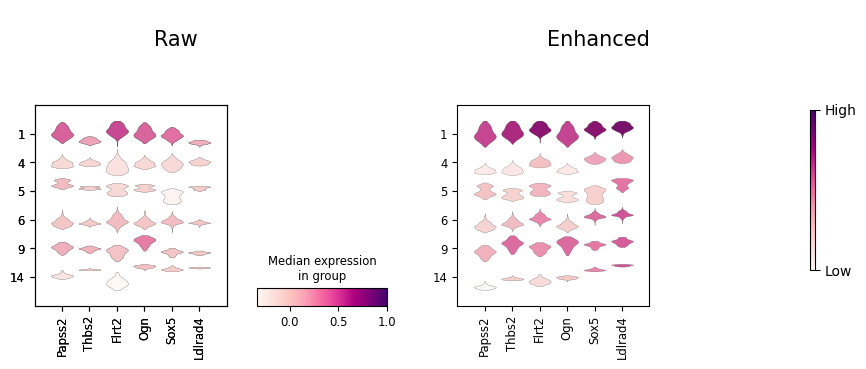

In [11]:
adata_recon = adata.copy()
adata_recon.X = adata.obsm['rec']

adata_recon.X /= (adata_recon.X.max(axis=0).reshape(1, -1)+1e-10)

adata.obsm['raw'] /= adata.obsm['raw'].max(axis=0).reshape(1, -1)

cmap = plt.get_cmap('RdPu')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Select clusters to show
mask = adata.obs['mclust'].isin([1,4,5,6,9,14])

sc.pl.stacked_violin(
    adata[mask], gene_names, groupby='mclust',
    vmax=1, ax=ax[0], show=False, cmap=cmap)

ax_dict = sc.pl.stacked_violin(adata[mask], gene_names, groupby='mclust', vmax=1, ax=ax[0], show=False, cmap=cmap)
ax_dict['color_legend_ax'].remove()

ax_dict = sc.pl.stacked_violin(adata_recon[mask], gene_names, groupby='mclust', vmax=1, ax=ax[1], show=False, cmap=cmap)
ax_dict['color_legend_ax'].remove()


norm = colors.Normalize(vmin=0, vmax=1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
loc, width, hight = 0.9, 0.005, 0.4
cbar_ax = fig.add_axes([loc, 0.2, width, hight])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low', 'High'])
fig.subplots_adjust(top=0.85)


ax[0].text(0.4, 0.9, 'Raw', ha='center', va='center', fontsize=15, transform=ax[0].transAxes)
ax[1].text(0.4, 0.9, 'Enhanced', ha='center', va='center', fontsize=15, transform=ax[1].transAxes)
    
plt.show()

**Box plot of marker genes**

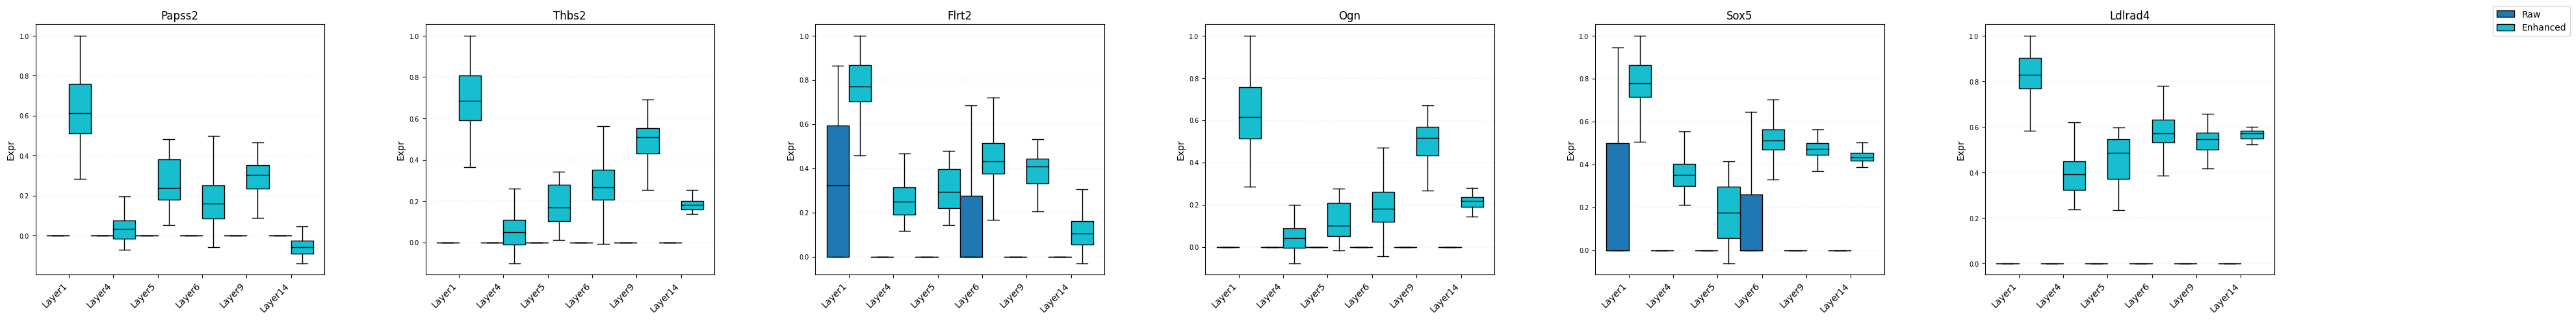

In [12]:
clusters = [1, 4, 5, 6, 9, 14]          # cluster list
labels   = [f'Layer{i}' for i in clusters] # Corresponding Layer names
n_genes  = len(gene_names)
n_cols   = 6
n_rows   = math.ceil(n_genes / n_cols)

# Canvas
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(7 * n_cols, 5 * n_rows),
                         constrained_layout=False)
axes = axes.flatten()

fig.subplots_adjust(left=0.06, right=0.88,
                    bottom=0.15, top=0.92,
                    wspace=0.35, hspace=0.45)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
x_pos  = np.arange(len(labels))  
width  = 0.5                 # Box width
offset = width / 2

# Plot each gene
for k, gene_name in enumerate(gene_names):
    if k >= n_genes:
        break
    ax = axes[k]

    idx = adata.var_names.get_loc(gene_name)

    # Collect expression vectors for specified clusters only
    raw_vecs   = [adata.obsm['raw'][adata.obs['mclust'] == c, idx] for c in clusters]
    recon_vecs = [adata_recon.X[adata.obs['mclust'] == c, idx] for c in clusters]

    # Raw
    bp1 = ax.boxplot(raw_vecs,
                     positions=x_pos - offset,
                     widths=width,
                     patch_artist=True,
                     showfliers=False)
    for b in bp1['boxes']:
        b.set_facecolor(colors[0])
        b.set_edgecolor('black')
    for m in bp1['medians']:
        m.set_color('black')

    # Enhanced
    bp2 = ax.boxplot(recon_vecs,
                     positions=x_pos + offset,
                     widths=width,
                     patch_artist=True,
                     showfliers=False)
    for b in bp2['boxes']:
        b.set_facecolor(colors[9])
        b.set_edgecolor('black')
    for m in bp2['medians']:
        m.set_color('black')

    # Titles, axes
    ax.set_title(gene_name)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Expr')
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(axis='y', ls='--', lw=0.3, alpha=0.4)

# Remove extra empty subplots
for j in range(n_genes, n_rows * n_cols):
    fig.delaxes(axes[j])

# Global legend
raw_patch   = mpatches.Patch(facecolor=colors[0], edgecolor='black', label='Raw')
recon_patch = mpatches.Patch(facecolor=colors[9], edgecolor='black', label='Enhanced')
fig.legend(handles=[raw_patch, recon_patch],
           loc='upper right',
           bbox_to_anchor=(0.99, 0.99)
           )

plt.show()
